In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [2]:
def plot_evolution(best_fit, title):
    plt.plot(best_fit) 
    plt.title(title)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')    
    plt.show()

def plot_result_comparisson(results, label_list):
    for i in range(len(results)):
        plt.plot(list(range(len(results[i]))), results[i], label = label_list[i])  
    plt.legend()
    plt.ylabel('Fitness')
    plt.xlabel('Generation') 
    plt.title("Results comparisson")
    plt.savefig(f'result_comp.png')
    plt.show()
    
def plot_time_comparisson(time, label_list):
    plt.barh(label_list,time)
    for index, value in enumerate(time):
        plt.text(value, index,"%.2f" %  value)
    plt.title("Time comparisson (seconds)")
    plt.savefig(f'time_comp.png')
    plt.show()
    

def plot_feasible_comparisson(val, label_list, feasible_time=None, epoch=None):
    plt.barh(label_list,val)
    for index, value in enumerate(val):
        plt.text(value, index,"%.2f" %  value)
    if feasible_time:
        plt.title(f"Result comparisson with time limit ({feasible_time} seconds)")
        plt.savefig(f'feasible_comp_{feasible_time}_seconds.png')
    elif epoch:
        plt.title(f"Result comparisson with epoch limit ({epoch} epochs)")
        plt.savefig(f'feasible_comp_{epoch}_epochs.png')
    plt.show()
    

# Rastrigin function
(https://en.wikipedia.org/wiki/Rastrigin_function)

In mathematical optimization, the Rastrigin function is a non-convex function used as a performance test problem for optimization algorithms due to a large amount of local minima. 

For our approach, the dimensions of the Rastrigin function will be 5, and A has fixed value of 10.

$ f(x) = A * d + sum(x_i^2 - A * cos(2 * pi * x_i)) $


PSO based of https://induraj2020.medium.com/implementing-particle-swarm-optimization-in-python-c59278bc5846

GA based of ChatGPT

# GA

Using a Genetic Algorithm approach with the values of X (5 dimensions) as individuals, and trying to minimize the Rastrigin function.

For this, the following parameters were fixed:
- Population size = 100
- Dimensions = 5
- Generations = 50
- Mutation rate = 0.1


In [3]:
"""
Class for genetic algorithm
Args:
    pop_size: number of individuals in population
    dimensions: number of dimensions for Rastringin problem
    generations: number of max generations to run
    mutation_rate: probability of mutation to occour
""" 
class GA:    
    def __init__(self, pop_size=100, dimensions=5, generations=50, mutation_rate = 0.1, feasible_time = None):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.feasible_time = feasible_time
    
    # Definition of Rastringin Function
    def rastrigin_function(self, x):
        A = 10
        return A * len(x) + sum([(np.power(xi, 2) - A * np.cos(2 * np.pi * xi)) for xi in x])
    
    # Initialize first population at random 
    def initialize_population(self, x_min=-5.12, x_max=5.12):
        return [np.random.uniform(x_min, x_max, self.dimensions) for _ in range(self.pop_size)]
    
    # Tournament selection of parents
    def tournament_selection(self, fitness_values, tournament_size=3):
        selected = []
        for _ in range(2):  # Select 2 parents
            tournament_indices = np.random.choice(len(self.population), tournament_size, replace=False)
            tournament_fitness = [fitness_values[i] for i in tournament_indices]
            selected.append(self.population[tournament_indices[np.argmin(tournament_fitness)]])
        return selected
    
    # Perform crossover between two individuals
    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]), axis=None)
        return child
    
    # Mutate child based on mutation rate
    def mutation(self, child):
        for i in range(len(child)):
            if np.random.rand() < self.mutation_rate:
                child[i] += np.random.uniform(-0.5, 0.5)  # Small random change
        return child
    
    # Run the algorithm
    def run_genetic_algorithm(self):
        start_time = time.time()
        best_solution = None
        best_fitness = float('inf')
        top_fitness = []
        if self.feasible_time:
            while time.time() - start_time < self.feasible_time:
                fitness_values = [self.rastrigin_function(ind) for ind in self.population]
                top_fitness.append(best_fitness)

                for i in range(self.pop_size // 2):
                    parent1, parent2 = self.tournament_selection(fitness_values)
                    child = self.crossover(parent1, parent2)
                    child = self.mutation(child)
                    self.population[i] = child

                best_idx = np.argmin(fitness_values)
                if fitness_values[best_idx] < best_fitness:
                    best_solution = self.population[best_idx]
                    best_fitness = fitness_values[best_idx]
        else:
            for _ in range(self.generations):
                fitness_values = [self.rastrigin_function(ind) for ind in self.population]
                top_fitness.append(best_fitness)

                for i in range(self.pop_size // 2):
                    parent1, parent2 = self.tournament_selection(fitness_values)
                    child = self.crossover(parent1, parent2)
                    child = self.mutation(child)
                    self.population[i] = child

                best_idx = np.argmin(fitness_values)
                if fitness_values[best_idx] < best_fitness:
                    best_solution = self.population[best_idx]
                    best_fitness = fitness_values[best_idx]

        return top_fitness, best_solution, best_fitness, time.time() - start_time


In [4]:
# GA results
ga = GA()
ga_top_fitness, ga_best_solution, ga_best_fitness, ga_time = ga.run_genetic_algorithm()
print("Best solution:", ga_best_solution)
print("Best fitness:", ga_best_fitness)

Best solution: [ 1.99249242 -1.01008223  1.95315676 -0.2319708  -1.29924467]
Best fitness: 7.603959586840148


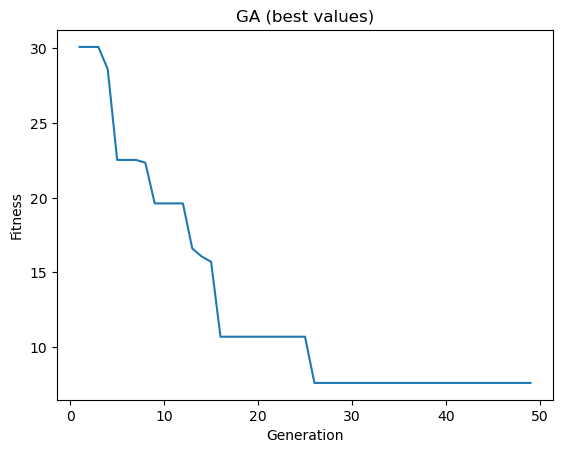

In [5]:
plot_evolution(ga_top_fitness, "GA (best values)")

# PSO
Using a Particle Swarm Optimization approach with the values of X (5 dimensions) as individuals, and trying to minimize the Rastrigin function. 

For this, the following parameters were fixed:
- Population size = 30
- Dimensions = 5
- Generations = 50
- Intertia weights (w) = 0.5
- Acceleration coefficient 1 (c1) = 1
- Acceleration coefficient 2 (c2) = 2


In [6]:
"""
Class for Particle Swarm Optimization
Args:
    pop_size: number of particles in population
    dimensions: number of dimensions for Rastringin problem
    generations: number of max generations to run
    w: intertia weights
    c1: acceleration coefficient 1
    c2: acceleration coefficient 2
""" 
class PSO:
    def __init__(self, pop_size=30, dimensions=5, generations=50, w=0.5, c1=1, c2=2, feasible_time = None):
        self.dim = dimensions
        self.num_particles = pop_size
        self.max_iter = generations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.feasible_time = feasible_time
        
    # Definition of Rastringin Function
    def rastrigin_function(self, x):
        A = 10
        return A * len(x) + sum([(np.power(xi, 2) - A * np.cos(2 * np.pi * xi)) for xi in x])
    
    # Execution of algorithm
    def pso_algorithm(self):
        start_time = time.time()

        particles = np.random.uniform(-5.12, 5.12, (self.num_particles, self.dim))
        velocities = np.zeros((self.num_particles, self.dim))
        top_fitness = []
        
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)
        if self.feasible_time:
            while time.time() - start_time < self.feasible_time:
                top_fitness.append(swarm_best_fitness)
                r1 = np.random.uniform(0, 1, (self.num_particles, self.dim))
                r2 = np.random.uniform(0, 1, (self.num_particles, self.dim))
                velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                            swarm_best_position - particles)
                particles += velocities

                fitness_values = np.array([self.rastrigin_function(p) for p in particles])

                improved_indices = np.where(fitness_values < best_fitness)
                best_positions[improved_indices] = particles[improved_indices]
                best_fitness[improved_indices] = fitness_values[improved_indices]
                if np.min(fitness_values) < swarm_best_fitness:
                    swarm_best_position = particles[np.argmin(fitness_values)]
                    swarm_best_fitness = np.min(fitness_values)
        else:
            for i in range(self.max_iter):
                top_fitness.append(swarm_best_fitness)
                r1 = np.random.uniform(0, 1, (self.num_particles, self.dim))
                r2 = np.random.uniform(0, 1, (self.num_particles, self.dim))
                velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                            swarm_best_position - particles)
                particles += velocities

                fitness_values = np.array([self.rastrigin_function(p) for p in particles])

                improved_indices = np.where(fitness_values < best_fitness)
                best_positions[improved_indices] = particles[improved_indices]
                best_fitness[improved_indices] = fitness_values[improved_indices]
                if np.min(fitness_values) < swarm_best_fitness:
                    swarm_best_position = particles[np.argmin(fitness_values)]
                    swarm_best_fitness = np.min(fitness_values)

        return top_fitness, swarm_best_position, swarm_best_fitness, time.time() - start_time


In [7]:
# PSO results
pso = PSO()
pso_top_fitness, pso_best_solution, pso_best_fitness, pso_time = pso.pso_algorithm()
print("Best solution:", pso_best_solution)
print("Best fitness:", pso_best_fitness)

Best solution: [ 0.00911969  0.98625049 -0.99892371 -0.00534178  0.99528283]
Best fitness: 3.0066364660205664


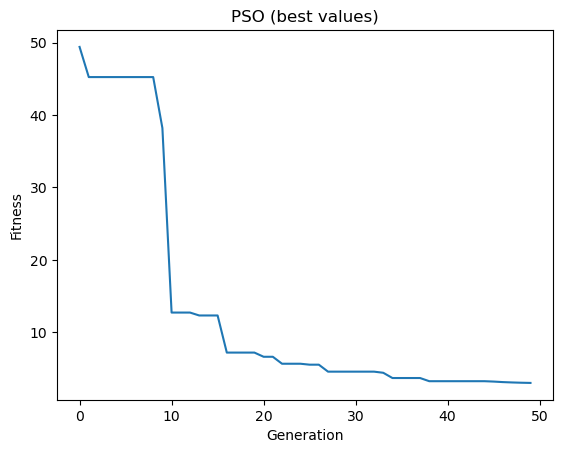

In [8]:
plot_evolution(pso_top_fitness, "PSO (best values)")

# Hybrid approaches
Application of techniques that mix PSO and GA to achieve better results, a few ideas are:
- Use GA to find best set of paremeters for PSO
- Use GA to get best set of individuals for PSO
- Alternate between GA and PSO


### Using GA to find best parameters for PSO
In this approach, the individuals of the Genetic Algorithm are the parameters for PSO (w, c1, c2). The fitness is defined by best result achived with PSO using those sets of parameters.

In [9]:
"""
Class to find best parameters for PSO via GA
"""
class PSO_GA_Parameters(GA):
    def __init__(self, pop_size=30, generations=50, mutation_rate = 0.1, feasible_time = None):
        self.pop_size = pop_size
        self.dimensions = 3 
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.feasible_time = feasible_time
    
    
    # Run the algorithm
    def run_algorithm(self):
        start_time = time.time()
        best_solution = None
        best_fitness = float('inf')
        top_fitness = []
        if self.feasible_time:
            while time.time() - start_time < self.feasible_time:
                fitness_values = []
                for ind in self.population:
                    pso = PSO(w=ind[0], c1=ind[1], c2=ind[2])
                    pso_top_fitness, pso_best_solution, pso_best_fitness, pso_time = pso.pso_algorithm()
                    fitness_values.append(pso_best_fitness)
                fitness_values = np.asarray(fitness_values)
                top_fitness.append(best_fitness)

                for i in range(self.pop_size // 2):
                    parent1, parent2 = self.tournament_selection(fitness_values)
                    child = self.crossover(parent1, parent2)
                    child = self.mutation(child)
                    self.population[i] = child

                best_idx = np.argmin(fitness_values)
                if fitness_values[best_idx] < best_fitness:
                    best_solution = self.population[best_idx]
                    best_fitness = fitness_values[best_idx]
        else:
            for _ in range(self.generations):
                fitness_values = []
                for ind in self.population:
                    pso = PSO(w=ind[0], c1=ind[1], c2=ind[2])
                    pso_top_fitness, pso_best_solution, pso_best_fitness, pso_time = pso.pso_algorithm()
                    fitness_values.append(pso_best_fitness)
                fitness_values = np.asarray(fitness_values)
                top_fitness.append(best_fitness)

                for i in range(self.pop_size // 2):
                    parent1, parent2 = self.tournament_selection(fitness_values)
                    child = self.crossover(parent1, parent2)
                    child = self.mutation(child)
                    self.population[i] = child

                best_idx = np.argmin(fitness_values)
                if fitness_values[best_idx] < best_fitness:
                    best_solution = self.population[best_idx]
                    best_fitness = fitness_values[best_idx]

        return top_fitness, best_solution, best_fitness, time.time() - start_time 


In [10]:
# GA for PSO paramters
pso_ga = PSO_GA_Parameters()
pso_ga_top_fitness, pso_ga_best_solution, pso_ga_best_fitness, pso_ga_time = pso_ga.run_algorithm()
print("Best solution (W, c1, c2):", pso_ga_best_solution)
print("Best fitness:", pso_ga_best_fitness)

Best solution (W, c1, c2): [0.75591797 0.75660476 0.82302211]
Best fitness: 0.6554350134727898


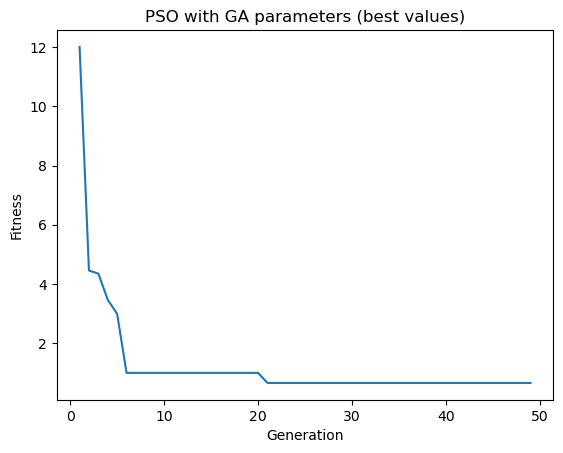

In [11]:
plot_evolution(pso_ga_top_fitness, "PSO with GA parameters (best values)")

## PSO with GA individuals
In this approach, the Genetic Algorithm is used to find the best population, which will be initial population of the Particle Swarm Optimization algorithm. 

In [12]:
"""
Class to find best individuals for PSO via GA
"""
class PSO_GA_Individuals(GA):
    def __init__(self, pop_size=100, dimensions=5, generations=50, mutation_rate = 0.1, w=0.5, c1=1, c2=2, feasible_time = None):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.feasible_time = feasible_time
        self.w = w
        self.c1 = c1
        self.c2 = c2
    
    # Run the algorithm
    def run_algorithm(self):
        start_time = time.time()
        for _ in range(self.generations):
            fitness_values = [self.rastrigin_function(ind) for ind in self.population]

            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child

        top_fitness, best_solution, best_fitness = self.pso_algorithm(self.population)
        return top_fitness, best_solution, best_fitness, time.time() - start_time
    
       # Execution of algorithm
    def pso_algorithm(self, particles):
        start_time = time.time()
        velocities = np.zeros((self.pop_size, self.dimensions))
        top_fitness = []
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)
        if self.feasible_time:
            while time.time() - start_time < self.feasible_time:
                top_fitness.append(swarm_best_fitness)
                r1 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
                r2 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
                velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                            swarm_best_position - particles)
                particles += velocities

                fitness_values = np.array([self.rastrigin_function(p) for p in particles])

                improved_indices = np.where(fitness_values < best_fitness)
                best_positions[improved_indices] = particles[improved_indices]
                best_fitness[improved_indices] = fitness_values[improved_indices]
                if np.min(fitness_values) < swarm_best_fitness:
                    swarm_best_position = particles[np.argmin(fitness_values)]
                    swarm_best_fitness = np.min(fitness_values)
        else: 
            for i in range(self.generations):
                top_fitness.append(swarm_best_fitness)
                r1 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
                r2 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
                velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                            swarm_best_position - particles)
                particles += velocities

                fitness_values = np.array([self.rastrigin_function(p) for p in particles])

                improved_indices = np.where(fitness_values < best_fitness)
                best_positions[improved_indices] = particles[improved_indices]
                best_fitness[improved_indices] = fitness_values[improved_indices]
                if np.min(fitness_values) < swarm_best_fitness:
                    swarm_best_position = particles[np.argmin(fitness_values)]
                    swarm_best_fitness = np.min(fitness_values)

        return top_fitness, swarm_best_position, swarm_best_fitness 


In [13]:
# PSO with GA individuals results
pso_ga_ind = PSO_GA_Individuals()
pso_ga_ind_top_fitness, pso_ga_ind_best_solution, pso_ga_ind_best_fitness, pso_ga_ind_time = pso_ga_ind.run_algorithm()
print("Best solution:", pso_ga_ind_best_solution)
print("Best fitness:", pso_ga_ind_best_fitness)

Best solution: [ 0.00490063 -0.99949684 -0.99184756 -0.99181159 -0.00289641]
Best fitness: 2.9928482792947335


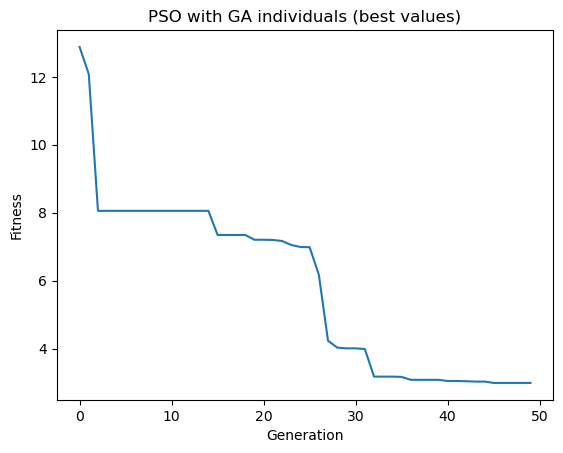

In [14]:
plot_evolution(pso_ga_ind_top_fitness, "PSO with GA individuals (best values)")

## Alternating PSO and GA
In this approach, GA is used to improve the population, which then is used by the PSO. The population results of the PSO is once again used by the GA. This alternation happens for 50 epochs.

In [15]:
"""
Class to alternate between GA and PSO
"""
class PSO_GA_Alternate(GA):
    def __init__(self, pop_size=100, dimensions=5, generations=50,mutation_rate = 0.1, w=0.5, c1=1, c2=2, feasible_time = None):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.alternate_epochs = 50
        self.feasible_time = feasible_time
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
    # Run the algorithm
    def run_algorithm(self):
        start_time = time.time()
        top_fitness = []
        if self.feasible_time:
            while time.time() - start_time < self.feasible_time:
                self.genetic_algorithm()
                best_solution, best_fitness = self.pso_algorithm()
                top_fitness.append(best_fitness)
        else: 
            for _ in range(self.alternate_epochs):
                self.genetic_algorithm()
                best_solution, best_fitness = self.pso_algorithm()
                top_fitness.append(best_fitness)
        return top_fitness, best_solution, best_fitness, time.time() - start_time
    
    # Execution of genetic algorithm
    def genetic_algorithm(self):
        for _ in range(self.generations):
            fitness_values = [self.rastrigin_function(ind) for ind in self.population]

            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child
    
    # Execution of algorithm
    def pso_algorithm(self):
        start_time = time.time()
        velocities = np.zeros((self.pop_size, self.dimensions))
        particles = self.population   
        top_fitness = []
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)   
        for i in range(self.generations):
            top_fitness.append(swarm_best_fitness)
            r1 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
            r2 = np.random.uniform(0, 1, (self.pop_size, self.dimensions))
            velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                        swarm_best_position - particles)
            particles += velocities

            fitness_values = np.array([self.rastrigin_function(p) for p in particles])

            improved_indices = np.where(fitness_values < best_fitness)
            best_positions[improved_indices] = particles[improved_indices]
            best_fitness[improved_indices] = fitness_values[improved_indices]
            if np.min(fitness_values) < swarm_best_fitness:
                swarm_best_position = particles[np.argmin(fitness_values)]
                swarm_best_fitness = np.min(fitness_values)
        self.population = particles 
   
        return swarm_best_position, swarm_best_fitness 

In [16]:
# PSO with GA alternating results
pso_ga_alt = PSO_GA_Alternate()
pso_ga_alt_top_fitness, pso_ga_alt_best_solution, pso_ga_alt_best_fitness, pso_ga_alt_time = pso_ga_alt.run_algorithm()
print("Best solution:", pso_ga_alt_best_solution)
print("Best fitness:", pso_ga_alt_best_fitness)

Best solution: [-1.71450142e-09 -1.38652342e-09 -9.94958639e-01 -7.87103601e-10
 -1.92382152e-10]
Best fitness: 0.9949590570932898


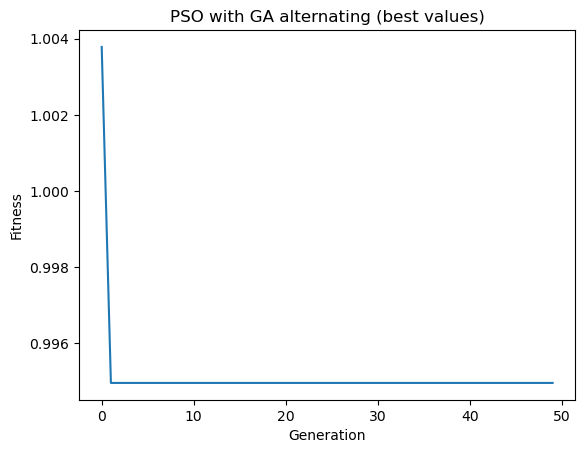

In [17]:
plot_evolution(pso_ga_alt_top_fitness, "PSO with GA alternating (best values)")

# Results

By running all algorithm with a fixed set of 50 epohcs, a few remarks can be made by analyzing the following pictures:
- GA performs the worst of them all.
- PSO has the worst initialization, which is improved by the hybrid approaches, but still had the second best result on the end of the 50 epochs.
- Out of all hybrid implementations, Alternating PSO/GA has the best initialization but doesn't decrease much.
- The best result was achieved by the PSO with GA parameters.
- Timewise, PSO with GA parameters takes the longest time, by a large difference, but still finds the best results in under a minute.
- To facilitate comparisson, the fixed epoch size has to be defined, if instead different approaches used different parameters, the comparisson could have been different ( for example, letting GA run for 1000 epochs, due to the slower converging rate it has.

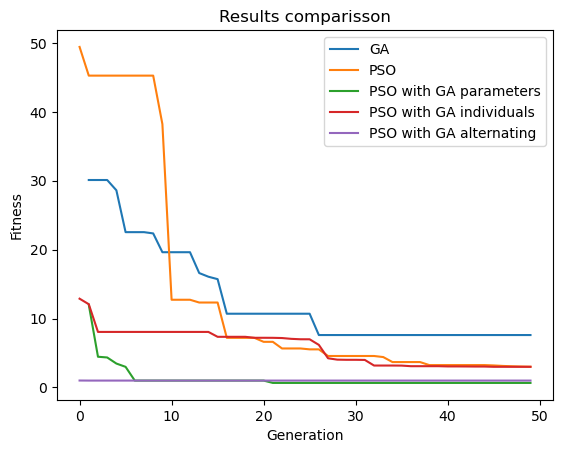

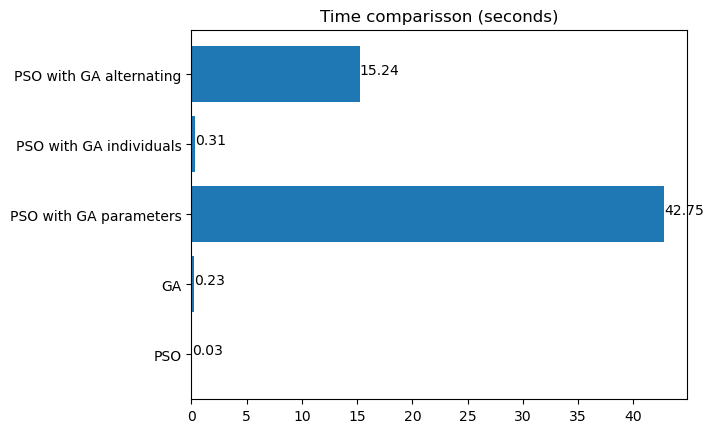

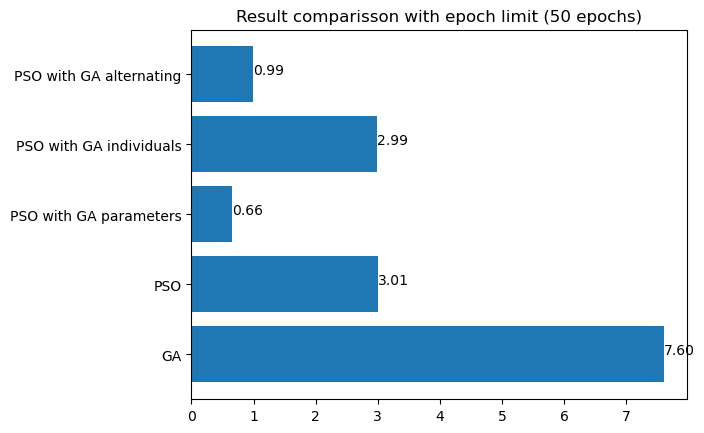

In [18]:
plot_result_comparisson([ga_top_fitness, pso_top_fitness, pso_ga_top_fitness, pso_ga_ind_top_fitness, pso_ga_alt_top_fitness],
                        ["GA","PSO","PSO with GA parameters","PSO with GA individuals","PSO with GA alternating"])
plot_time_comparisson([pso_time, ga_time, pso_ga_time,pso_ga_ind_time, pso_ga_alt_time],
                      ["PSO","GA","PSO with GA parameters", "PSO with GA individuals", "PSO with GA alternating"])
plot_feasible_comparisson([ga_best_fitness, pso_best_fitness, pso_ga_best_fitness, pso_ga_ind_best_fitness, pso_ga_alt_best_fitness],
                        ["GA","PSO","PSO with GA parameters","PSO with GA individuals","PSO with GA alternating"],
                       epoch= 50)


# Feasible time
Define a feasible time and run all methods until this time, then compare results.

In [19]:
feasible_time = 60 #seconds
print("-------START-------")
# GA standalone
time_ga = GA(feasible_time=feasible_time)
time_ga_top_fitness, time_ga_best_solution, time_ga_best_fitness, time_ga_time = time_ga.run_genetic_algorithm()
print(f"GA standalone time: {time_ga_time}")

# PSO standalone
time_pso = PSO(feasible_time=feasible_time)
time_pso_top_fitness, time_pso_best_solution, time_pso_best_fitness, time_pso_time = time_pso.pso_algorithm()
print(f"PSO standalone time: {time_pso_time}")

# GA for PSO paramters
time_pso_ga = PSO_GA_Parameters(feasible_time=feasible_time)
time_pso_ga_top_fitness, time_pso_ga_best_solution, time_pso_ga_best_fitness, time_pso_ga_time = time_pso_ga.run_algorithm()
print(f"GA for PSO paramters time: {time_pso_ga_time}")

# PSO with GA individuals 
time_pso_ga_ind = PSO_GA_Individuals(feasible_time=feasible_time)
time_pso_ga_ind_top_fitness, time_pso_ga_ind_best_solution, time_pso_ga_ind_best_fitness, time_pso_ga_ind_time = time_pso_ga_ind.run_algorithm()
print(f"PSO with GA individuals time: {time_pso_ga_ind_time}")

# PSO with GA alternating 
time_pso_ga_alt = PSO_GA_Alternate(feasible_time=feasible_time)
time_pso_ga_alt_top_fitness, time_pso_ga_alt_best_solution, time_pso_ga_alt_best_fitness, time_pso_ga_alt_time = time_pso_ga_alt.run_algorithm()
print(f"PSO with GA alternating results time: {time_pso_ga_alt_time}")
print("--------END--------")

-------START-------
GA standalone time: 60.00530695915222
PSO standalone time: 60.0000479221344
GA for PSO paramters time: 60.2485990524292
PSO with GA individuals time: 60.233163833618164
PSO with GA alternating results time: 60.1746985912323
--------END--------


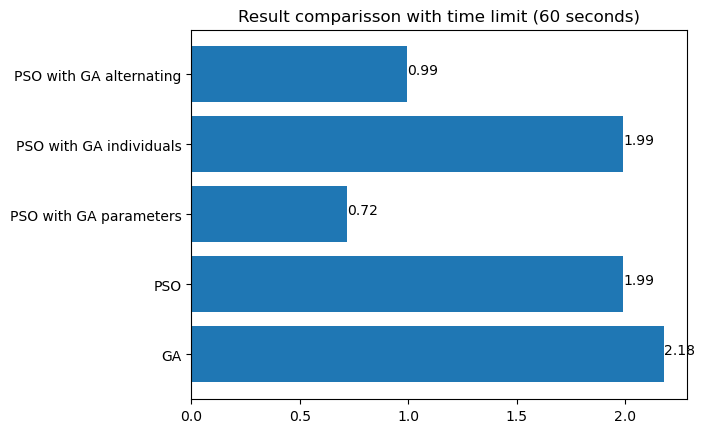

In [20]:

    
plot_feasible_comparisson([time_ga_best_fitness, time_pso_best_fitness, time_pso_ga_best_fitness, time_pso_ga_ind_best_fitness, time_pso_ga_alt_best_fitness], 
                          ["GA","PSO","PSO with GA parameters","PSO with GA individuals","PSO with GA alternating"], 
                          feasible_time)


In [24]:
# make table
names = ["GA","PSO","PSO with GA parameters","PSO with GA individuals","PSO with GA alternating"]

# Creating the patient_name in the df data frame
df = pd.DataFrame()
df["Method"] = names
df["50 epoch"] = [ga_best_fitness, pso_best_fitness, pso_ga_best_fitness, pso_ga_ind_best_fitness, pso_ga_alt_best_fitness]
df["1 minute"] = [time_ga_best_fitness, time_pso_best_fitness, time_pso_ga_best_fitness, time_pso_ga_ind_best_fitness, time_pso_ga_alt_best_fitness]

,Method,50 epoch,1 minute
0,GA,7.604,2.178
1,PSO,3.007,1.990
2,PSO with GA parameters,0.655,0.719
3,PSO with GA individuals,2.993,1.990
4,PSO with GA alternating,0.995,0.995


In [27]:
attempts = 10
l_ga = np.zeros(attempts)
l_pso = np.zeros(attempts)
l_pso_ga_param = np.zeros(attempts)
l_ga_pso_ind = np.zeros(attempts)
l_ga_pso_alt = np.zeros(attempts)
for i in range(attempts):
    print(f"Loop {i}")
    # GA standalone
    ga = GA()
    _, _, ga_best_fitness, _ = ga.run_genetic_algorithm()
    l_ga[i] = ga_best_fitness
    # PSO standalone
    pso = PSO()
    _, _, pso_best_fitness, _ = pso.pso_algorithm()
    l_pso[i] = pso_best_fitness
    # GA for PSO paramters
    pso_ga = PSO_GA_Parameters()
    _, _, pso_ga_best_fitness, _ = pso_ga.run_algorithm()
    l_pso_ga_param[i]=pso_ga_best_fitness
    # PSO with GA individuals 
    pso_ga_ind = PSO_GA_Individuals()
    _, _, pso_ga_ind_best_fitness, _ = pso_ga_ind.run_algorithm()
    l_ga_pso_ind[i] = pso_ga_ind_best_fitness
    # PSO with GA alternating 
    pso_ga_alt = PSO_GA_Alternate()
    _, _, time_pso_ga_alt_best_fitness, _ = pso_ga_alt.run_algorithm()
    l_ga_pso_alt[i] = time_pso_ga_alt_best_fitness

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9


In [ ]:
df["50 epochs avg"] = [np.mean(l_ga),np.mean(l_pso),np.mean(l_pso_ga_param),np.mean(l_ga_pso_ind),np.mean(l_ga_pso_alt)]

In [ ]:
rounded_df = df.round(decimals=3)
rounded_df

,Method,50 epoch,1 minute,50 epochs avg
0,GA,7.604,2.178,10.225
1,PSO,3.007,1.990,4.298
2,PSO with GA parameters,0.655,0.719,1.819
3,PSO with GA individuals,2.993,1.990,2.750
4,PSO with GA alternating,0.995,0.995,2.288


In [30]:
attempts = 10
l_ga = np.zeros(attempts)
l_pso = np.zeros(attempts)
l_pso_ga_param = np.zeros(attempts)
l_ga_pso_ind = np.zeros(attempts)
l_ga_pso_alt = np.zeros(attempts)
for i in range(attempts):
    print(f"Loop {i}")
    # GA standalone
    ga = GA(feasible_time=feasible_time)
    _, _, ga_best_fitness, _ = ga.run_genetic_algorithm()
    l_ga[i] = ga_best_fitness
    # PSO standalone
    pso = PSO(feasible_time=feasible_time)
    _, _, pso_best_fitness, _ = pso.pso_algorithm()
    l_pso[i] = pso_best_fitness
    # GA for PSO paramters
    pso_ga = PSO_GA_Parameters(feasible_time=feasible_time)
    _, _, pso_ga_best_fitness, _ = pso_ga.run_algorithm()
    l_pso_ga_param[i]=pso_ga_best_fitness
    # PSO with GA individuals 
    pso_ga_ind = PSO_GA_Individuals(feasible_time=feasible_time)
    _, _, pso_ga_ind_best_fitness, _ = pso_ga_ind.run_algorithm()
    l_ga_pso_ind[i] = pso_ga_ind_best_fitness
    # PSO with GA alternating 
    pso_ga_alt = PSO_GA_Alternate(feasible_time=feasible_time)
    _, _, time_pso_ga_alt_best_fitness, _ = pso_ga_alt.run_algorithm()
    l_ga_pso_alt[i] = time_pso_ga_alt_best_fitness
df["1 minute avg"] = [np.mean(l_ga),np.mean(l_pso),np.mean(l_pso_ga_param),np.mean(l_ga_pso_ind),np.mean(l_ga_pso_alt)]

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9


In [33]:
rounded_df = df.round(decimals=3)
rounded_df

,Method,50 epoch,1 minute,50 epochs avg,1 minute avg
0,GA,7.604,2.178,10.225,3.590
1,PSO,3.007,1.990,4.298,4.676
2,PSO with GA parameters,0.655,0.719,1.819,0.938
3,PSO with GA individuals,2.993,1.990,2.750,1.592
4,PSO with GA alternating,0.995,0.995,2.288,1.094


In [34]:
rounded_df.to_csv("results.csv",index=False)